In [1]:
#importando as bbts
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import random
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#caminho para o dataset
dataset_path = '/content/drive/MyDrive/trabalho_visao/BrainTumor_MRI_Scans'

#configurações principais
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#transformações de imagem
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #redimensiona as imagens para 224x224
    transforms.RandomHorizontalFlip(),  #aplica flip horizontal aleatório
    transforms.RandomRotation(10),  #aplica rotação aleatória de até 10 graus
    transforms.ToTensor(),  #converte para tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #normaliza com os valores de ImageNet
])

#carregando o dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [ ]:
def show_class_samples(dataset, num_samples=3):
    #obter as classes do dataset
    classes = dataset.classes

    #configuração do gráfico
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 3, len(classes) * 3))

    for i, cls in enumerate(classes):
        #filtra as imagens da classe
        class_idx = dataset.class_to_idx[cls]
        #obtém caminhos das imagens e verifica se o arquivo existe
        class_images = [img for img, label in dataset.samples if label == class_idx and os.path.isfile(img)]

        # Verifica se há imagens suficientes para a classe
        if len(class_images) < num_samples:
            print(f"Erro: A classe '{cls}' tem apenas {len(class_images)} imagens disponíveis. Ajustando para exibir todas.")
            selected_images = class_images  #exibe todas as disponíveis
        else:
            selected_images = random.sample(class_images, num_samples)  #seleciona imagens aleatórias

        for j, img_path in enumerate(selected_images):
            #abre e exibe a imagem
            img = Image.open(img_path)  #img_path é o caminho da imagem
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{cls} imagens", fontsize=14)

    plt.tight_layout()
    plt.show()

#exibindo amostras para as classes do dataset
show_class_samples(dataset)

In [ ]:
#dividindo o dataset em treino, validação e teste
train_val_dataset, test_dataset = train_test_split(dataset, test_size=0.15, random_state=42)
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.15, random_state=42)

#criando DataLoaders para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#definindo o número de folds
k_folds = 5

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [7]:
#função para treinar o modelo
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            #zera os gradientes
            optimizer.zero_grad()

            #forward e cálculo de perda
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            #backward e atualização dos pesos
            loss.backward()
            optimizer.step()

            #estatísticas
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acurácia: {epoch_acc:.2f}%")
        torch.cuda.empty_cache()
        gc.collect()
    return model

In [8]:
#função para avaliar o modelo
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [9]:
def cross_validate_model(model, dataset, k_folds=5, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        #criando DataLoaders para o conjunto de treino e validação
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
        val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size)

        #criando uma nova cópia do modelo para cada fold
        model_fold = deepcopy(model).to(device)

        #configurando critério e otimizador
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_fold.parameters(), lr=0.001)

        #treinando o modelo
        model_fold = train_model(model_fold, train_loader, criterion, optimizer, num_epochs)

        #avaliando no conjunto de validação
        y_true, y_pred = evaluate_model(model_fold, val_loader, device)

        #matriz de confusão
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
        plt.title(f'Matriz de Confusão para Fold {fold + 1}')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()

        torch.cuda.empty_cache()
        gc.collect()

        #relatório de classificação
        print(f"\nRelatório de Classificação para Fold {fold + 1}:")
        print(classification_report(y_true, y_pred, target_names=dataset.classes))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.2MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.0MB/s]



Treinando com validação cruzada - Modelo: VGG16
Fold 1/5
Epoch 1/10, Loss: 1.1128, Acurácia: 50.02%
Epoch 2/10, Loss: 0.6665, Acurácia: 71.18%
Epoch 3/10, Loss: 0.5687, Acurácia: 76.70%
Epoch 4/10, Loss: 0.4950, Acurácia: 81.22%
Epoch 5/10, Loss: 0.4331, Acurácia: 82.95%
Epoch 6/10, Loss: 0.4193, Acurácia: 84.85%
Epoch 7/10, Loss: 0.3605, Acurácia: 86.85%
Epoch 8/10, Loss: 0.3672, Acurácia: 86.26%
Epoch 9/10, Loss: 0.3307, Acurácia: 87.50%
Epoch 10/10, Loss: 0.3080, Acurácia: 88.71%


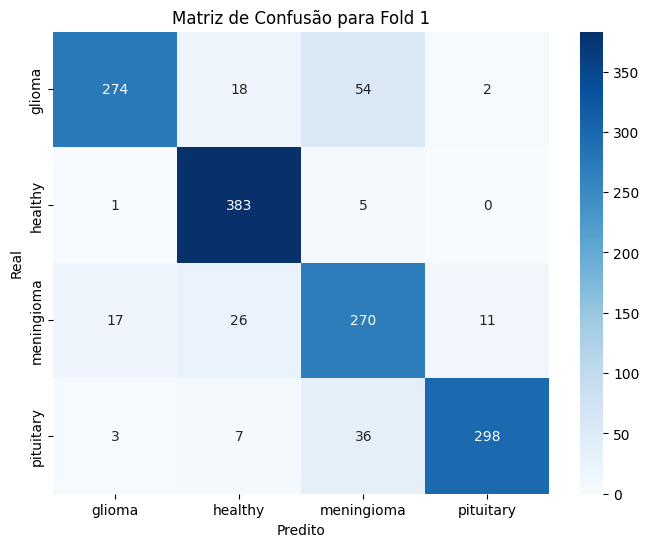


Relatório de Classificação para Fold 1:
              precision    recall  f1-score   support

      glioma       0.93      0.79      0.85       348
     healthy       0.88      0.98      0.93       389
  meningioma       0.74      0.83      0.78       324
   pituitary       0.96      0.87      0.91       344

    accuracy                           0.87      1405
   macro avg       0.88      0.87      0.87      1405
weighted avg       0.88      0.87      0.87      1405

Fold 2/5
Epoch 1/10, Loss: 1.0903, Acurácia: 51.25%
Epoch 2/10, Loss: 0.6724, Acurácia: 69.47%
Epoch 3/10, Loss: 0.5810, Acurácia: 75.15%
Epoch 4/10, Loss: 0.5352, Acurácia: 76.77%
Epoch 5/10, Loss: 0.4834, Acurácia: 79.94%
Epoch 6/10, Loss: 0.4750, Acurácia: 80.90%
Epoch 7/10, Loss: 0.3816, Acurácia: 85.05%
Epoch 8/10, Loss: 0.3332, Acurácia: 87.95%
Epoch 9/10, Loss: 0.2887, Acurácia: 89.28%
Epoch 10/10, Loss: 0.3024, Acurácia: 88.93%


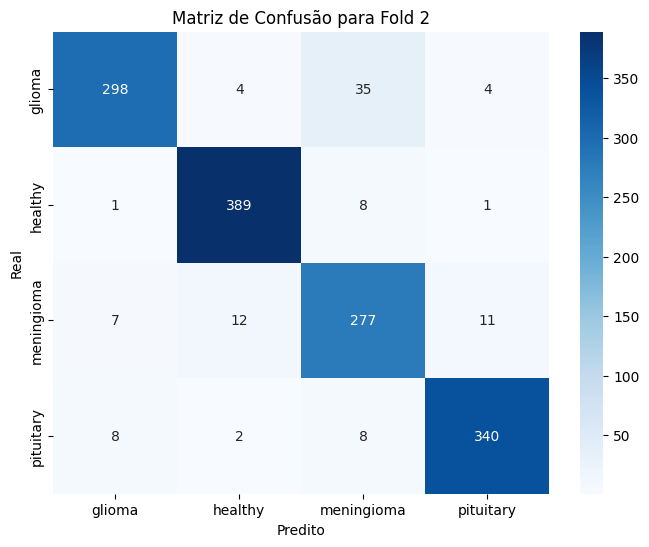


Relatório de Classificação para Fold 2:
              precision    recall  f1-score   support

      glioma       0.95      0.87      0.91       341
     healthy       0.96      0.97      0.97       399
  meningioma       0.84      0.90      0.87       307
   pituitary       0.96      0.95      0.95       358

    accuracy                           0.93      1405
   macro avg       0.93      0.93      0.93      1405
weighted avg       0.93      0.93      0.93      1405

Fold 3/5
Epoch 1/10, Loss: 1.0815, Acurácia: 51.80%
Epoch 2/10, Loss: 0.7704, Acurácia: 67.18%
Epoch 3/10, Loss: 0.6351, Acurácia: 74.44%
Epoch 4/10, Loss: 0.5291, Acurácia: 80.37%
Epoch 5/10, Loss: 0.4497, Acurácia: 82.84%
Epoch 6/10, Loss: 0.4189, Acurácia: 84.62%
Epoch 7/10, Loss: 0.4146, Acurácia: 84.64%
Epoch 8/10, Loss: 0.3907, Acurácia: 85.32%
Epoch 9/10, Loss: 0.3518, Acurácia: 86.76%
Epoch 10/10, Loss: 0.3472, Acurácia: 86.72%


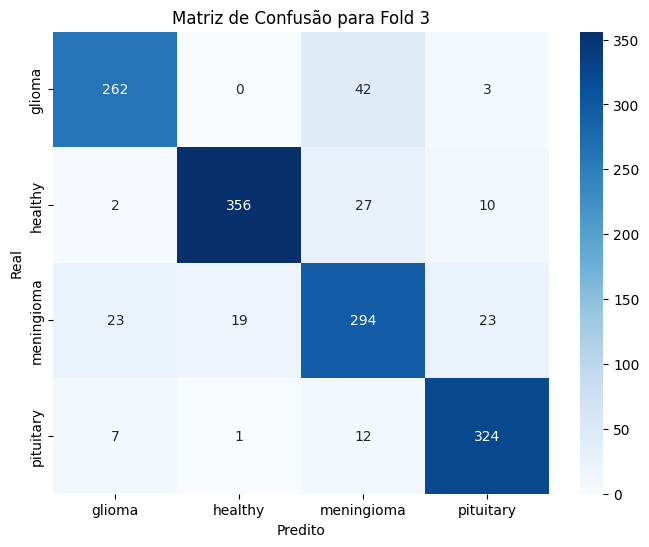


Relatório de Classificação para Fold 3:
              precision    recall  f1-score   support

      glioma       0.89      0.85      0.87       307
     healthy       0.95      0.90      0.92       395
  meningioma       0.78      0.82      0.80       359
   pituitary       0.90      0.94      0.92       344

    accuracy                           0.88      1405
   macro avg       0.88      0.88      0.88      1405
weighted avg       0.88      0.88      0.88      1405

Fold 4/5
Epoch 1/10, Loss: 1.0099, Acurácia: 54.07%
Epoch 2/10, Loss: 0.6167, Acurácia: 75.65%
Epoch 3/10, Loss: 0.5403, Acurácia: 79.07%
Epoch 4/10, Loss: 0.4609, Acurácia: 82.24%
Epoch 5/10, Loss: 0.4516, Acurácia: 82.19%
Epoch 6/10, Loss: 0.3811, Acurácia: 85.58%
Epoch 7/10, Loss: 0.3755, Acurácia: 85.89%
Epoch 8/10, Loss: 0.4061, Acurácia: 85.16%
Epoch 9/10, Loss: 0.3211, Acurácia: 87.58%
Epoch 10/10, Loss: 0.3367, Acurácia: 87.44%


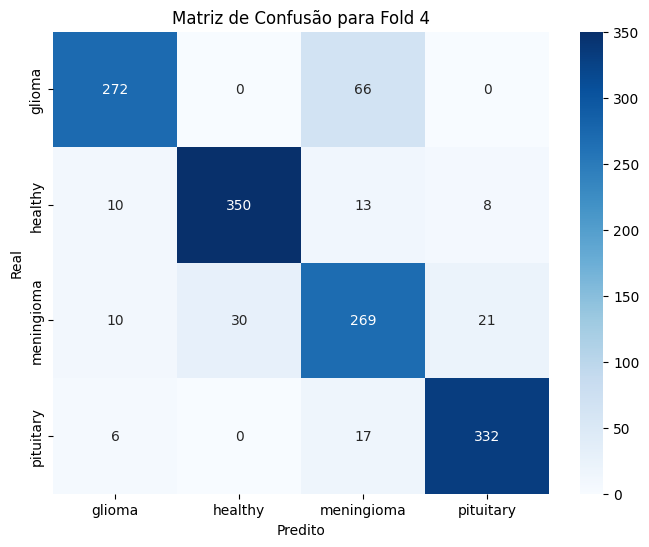


Relatório de Classificação para Fold 4:
              precision    recall  f1-score   support

      glioma       0.91      0.80      0.86       338
     healthy       0.92      0.92      0.92       381
  meningioma       0.74      0.82      0.77       330
   pituitary       0.92      0.94      0.93       355

    accuracy                           0.87      1404
   macro avg       0.87      0.87      0.87      1404
weighted avg       0.88      0.87      0.87      1404

Fold 5/5
Epoch 1/10, Loss: 1.0478, Acurácia: 52.30%
Epoch 2/10, Loss: 0.6793, Acurácia: 69.51%
Epoch 3/10, Loss: 0.6020, Acurácia: 73.82%
Epoch 4/10, Loss: 0.5356, Acurácia: 78.45%
Epoch 5/10, Loss: 0.5254, Acurácia: 78.98%
Epoch 6/10, Loss: 0.4409, Acurácia: 82.59%
Epoch 7/10, Loss: 0.4046, Acurácia: 84.84%
Epoch 8/10, Loss: 0.4058, Acurácia: 84.09%
Epoch 9/10, Loss: 0.3577, Acurácia: 86.26%
Epoch 10/10, Loss: 0.3548, Acurácia: 86.24%


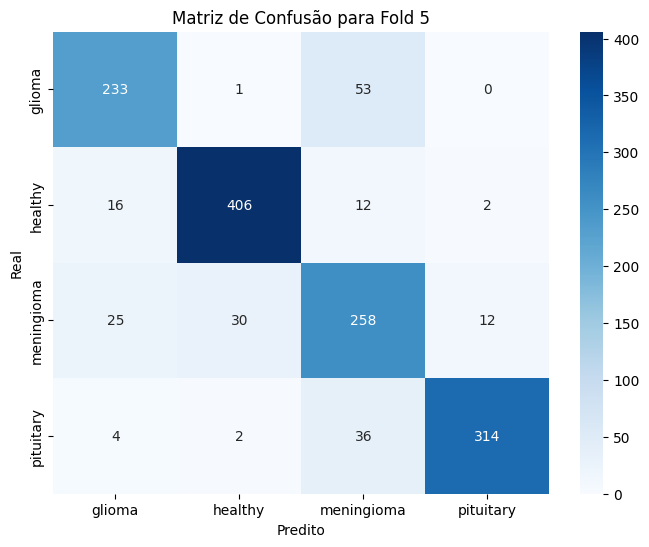


Relatório de Classificação para Fold 5:
              precision    recall  f1-score   support

      glioma       0.84      0.81      0.82       287
     healthy       0.92      0.93      0.93       436
  meningioma       0.72      0.79      0.75       325
   pituitary       0.96      0.88      0.92       356

    accuracy                           0.86      1404
   macro avg       0.86      0.85      0.86      1404
weighted avg       0.87      0.86      0.86      1404


Treinando com validação cruzada - Modelo: ResNet18
Fold 1/5
Epoch 1/10, Loss: 0.3843, Acurácia: 86.49%
Epoch 2/10, Loss: 0.1887, Acurácia: 93.11%
Epoch 3/10, Loss: 0.1477, Acurácia: 94.75%
Epoch 4/10, Loss: 0.0983, Acurácia: 96.55%
Epoch 5/10, Loss: 0.1017, Acurácia: 96.44%
Epoch 6/10, Loss: 0.0734, Acurácia: 97.42%
Epoch 7/10, Loss: 0.0892, Acurácia: 96.90%
Epoch 8/10, Loss: 0.0547, Acurácia: 98.24%
Epoch 9/10, Loss: 0.0689, Acurácia: 97.70%
Epoch 10/10, Loss: 0.0550, Acurácia: 98.18%


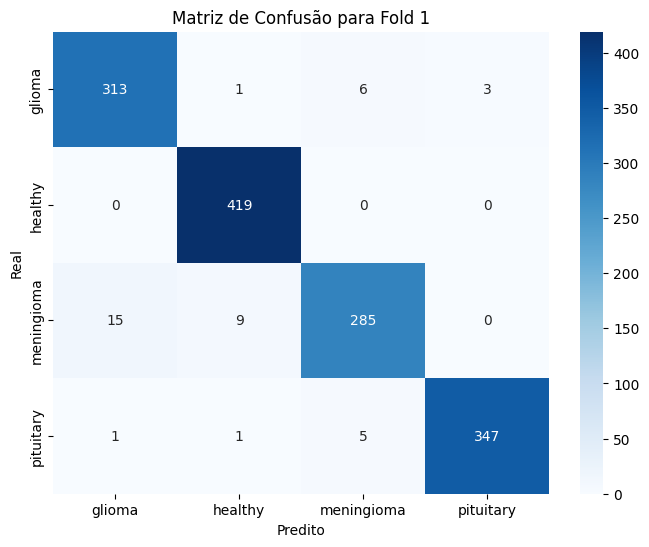


Relatório de Classificação para Fold 1:
              precision    recall  f1-score   support

      glioma       0.95      0.97      0.96       323
     healthy       0.97      1.00      0.99       419
  meningioma       0.96      0.92      0.94       309
   pituitary       0.99      0.98      0.99       354

    accuracy                           0.97      1405
   macro avg       0.97      0.97      0.97      1405
weighted avg       0.97      0.97      0.97      1405

Fold 2/5
Epoch 1/10, Loss: 0.3652, Acurácia: 86.92%
Epoch 2/10, Loss: 0.1891, Acurácia: 93.65%
Epoch 3/10, Loss: 0.1458, Acurácia: 94.98%
Epoch 4/10, Loss: 0.1121, Acurácia: 95.94%
Epoch 5/10, Loss: 0.0884, Acurácia: 96.74%
Epoch 6/10, Loss: 0.0742, Acurácia: 97.35%
Epoch 7/10, Loss: 0.0918, Acurácia: 96.74%
Epoch 8/10, Loss: 0.0819, Acurácia: 97.13%
Epoch 9/10, Loss: 0.0534, Acurácia: 98.08%
Epoch 10/10, Loss: 0.0466, Acurácia: 98.54%


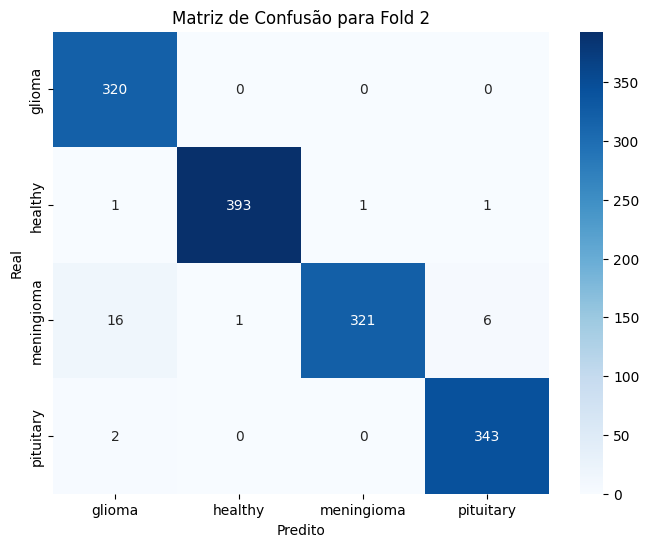


Relatório de Classificação para Fold 2:
              precision    recall  f1-score   support

      glioma       0.94      1.00      0.97       320
     healthy       1.00      0.99      0.99       396
  meningioma       1.00      0.93      0.96       344
   pituitary       0.98      0.99      0.99       345

    accuracy                           0.98      1405
   macro avg       0.98      0.98      0.98      1405
weighted avg       0.98      0.98      0.98      1405

Fold 3/5
Epoch 1/10, Loss: 0.3329, Acurácia: 88.50%
Epoch 2/10, Loss: 0.1725, Acurácia: 93.59%
Epoch 3/10, Loss: 0.1353, Acurácia: 95.32%
Epoch 4/10, Loss: 0.1132, Acurácia: 96.05%
Epoch 5/10, Loss: 0.1078, Acurácia: 96.32%
Epoch 6/10, Loss: 0.0651, Acurácia: 97.69%
Epoch 7/10, Loss: 0.0756, Acurácia: 97.45%
Epoch 8/10, Loss: 0.0610, Acurácia: 98.01%
Epoch 9/10, Loss: 0.0680, Acurácia: 97.65%
Epoch 10/10, Loss: 0.0442, Acurácia: 98.50%


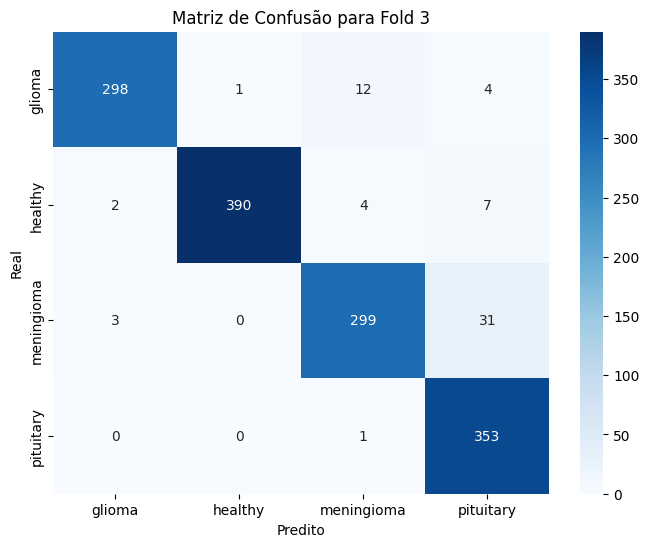


Relatório de Classificação para Fold 3:
              precision    recall  f1-score   support

      glioma       0.98      0.95      0.96       315
     healthy       1.00      0.97      0.98       403
  meningioma       0.95      0.90      0.92       333
   pituitary       0.89      1.00      0.94       354

    accuracy                           0.95      1405
   macro avg       0.96      0.95      0.95      1405
weighted avg       0.96      0.95      0.95      1405

Fold 4/5
Epoch 1/10, Loss: 0.3276, Acurácia: 88.31%
Epoch 2/10, Loss: 0.1805, Acurácia: 93.58%
Epoch 3/10, Loss: 0.1267, Acurácia: 95.73%
Epoch 4/10, Loss: 0.1058, Acurácia: 96.46%
Epoch 5/10, Loss: 0.0946, Acurácia: 96.94%
Epoch 6/10, Loss: 0.0912, Acurácia: 96.90%
Epoch 7/10, Loss: 0.0524, Acurácia: 98.26%
Epoch 8/10, Loss: 0.0604, Acurácia: 98.01%
Epoch 9/10, Loss: 0.0565, Acurácia: 97.97%
Epoch 10/10, Loss: 0.0490, Acurácia: 98.22%


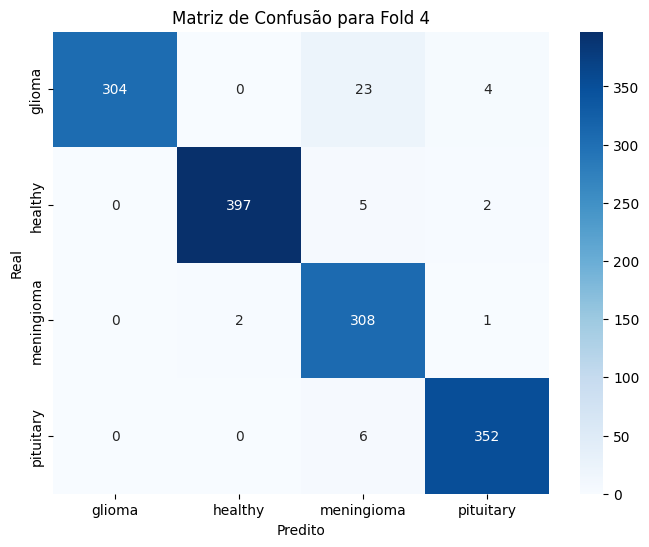


Relatório de Classificação para Fold 4:
              precision    recall  f1-score   support

      glioma       1.00      0.92      0.96       331
     healthy       0.99      0.98      0.99       404
  meningioma       0.90      0.99      0.94       311
   pituitary       0.98      0.98      0.98       358

    accuracy                           0.97      1404
   macro avg       0.97      0.97      0.97      1404
weighted avg       0.97      0.97      0.97      1404

Fold 5/5
Epoch 1/10, Loss: 0.3575, Acurácia: 87.29%
Epoch 2/10, Loss: 0.2004, Acurácia: 93.08%
Epoch 3/10, Loss: 0.1482, Acurácia: 94.71%
Epoch 4/10, Loss: 0.1075, Acurácia: 96.28%
Epoch 5/10, Loss: 0.1053, Acurácia: 96.21%
Epoch 6/10, Loss: 0.0717, Acurácia: 97.54%
Epoch 7/10, Loss: 0.0735, Acurácia: 97.37%
Epoch 8/10, Loss: 0.0704, Acurácia: 97.65%
Epoch 9/10, Loss: 0.0648, Acurácia: 97.70%
Epoch 10/10, Loss: 0.0499, Acurácia: 98.43%


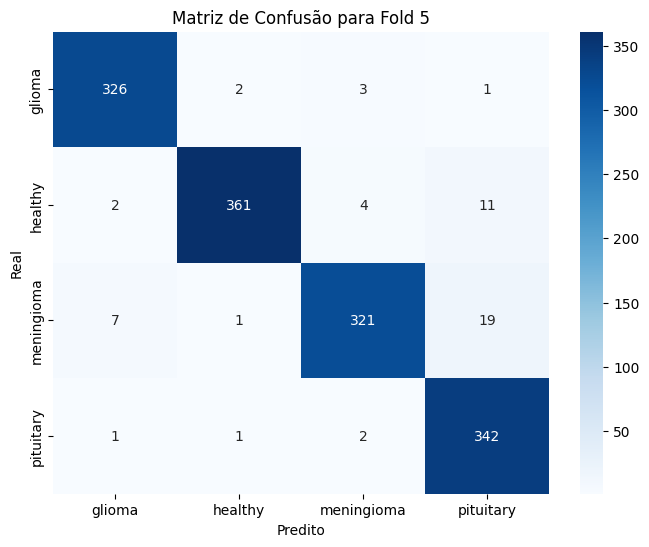


Relatório de Classificação para Fold 5:
              precision    recall  f1-score   support

      glioma       0.97      0.98      0.98       332
     healthy       0.99      0.96      0.97       378
  meningioma       0.97      0.92      0.95       348
   pituitary       0.92      0.99      0.95       346

    accuracy                           0.96      1404
   macro avg       0.96      0.96      0.96      1404
weighted avg       0.96      0.96      0.96      1404



In [10]:
#treinando e avaliando os modelos com validação cruzada
models_to_train = {
    "VGG16": models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1),
    "ResNet18": models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1),
}

#ajustando a última camada do VGG16
num_classes = len(dataset.classes)
models_to_train["VGG16"].classifier[6] = nn.Linear(4096, num_classes)

#ajustando a última camada do ResNet18
num_classes = len(dataset.classes)
models_to_train["ResNet18"].fc = nn.Linear(models_to_train["ResNet18"].fc.in_features, num_classes)

for model_name, model in models_to_train.items():
    print(f"\nTreinando com validação cruzada - Modelo: {model_name}")
    cross_validate_model(model, dataset, k_folds=5, num_epochs=10)